In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares,root
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_network
import ring_network as ring_network
import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ
import dmft

def addcbar(fig,ax,plot,size='5%',pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=size, pad=pad)
    cbar = fig.colorbar(plot, cax=cax, orientation='vertical')
    return cbar

In [3]:
import dmft

id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_None_n_75.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_best_fit_v1_n_9.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']
    
ri = ric.Ricciardi()

In [4]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

# res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
# res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='opto',return_full=True)

with open('./../results/dmft_best_fit_id_None_c_{:d}'.format(5)+'.pkl','rb') as\
        handle:
    this_res_dict = pickle.load(handle)['dmft_res']
    res_dict_init = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}
    res_dict_pert = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}
    
rvb = res_dict_init['rb']
rvp = res_dict_init['rp']
sr = res_dict_init['sr']
Crvb = res_dict_init['Crb']
Crvp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

rob = res_dict_pert['rb']
rop = res_dict_pert['rp']
Crob = res_dict_pert['Crb']
Crop = res_dict_pert['Crp']

In [5]:
FE,FI,ME,MI,CE,CI = dmft.base_itp_moments('./../results')
FL,ML,CL = dmft.opto_itp_moments('./../results',prms['L'],prms['CVL'])
    
def base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

def opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
H = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX

muH = tau*H
SigH = (muH*eH)**2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

block_muW = np.block([
    [muWbb,muWbp],
    [muWpb,muWpp]
])
block_SigW = np.block([
    [SigWbb,SigWbp],
    [SigWpb,SigWpp]
])

def block_base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ME(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CE(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

def block_opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ML(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CL(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

In [157]:
reload(dmft)

block_mu = np.concatenate([res_dict_init['mub'],res_dict_init['mup']])
block_Sig = np.concatenate([res_dict_init['Sigb'],res_dict_init['Sigp']],0)

res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       np.zeros(4),np.zeros(4),block_base_M,block_base_C,Tsav,dt,
                                       block_mu,block_Sig)

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]
# E = res_dict_lin_resp['E']
# F = res_dict_lin_resp['F']

Abb,Abp,Apb,App = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
Bbb,Bbp,Bpb,Bpp = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
Cbb,Cbp,Cpb,Cpp = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
Dbb,Dbp,Dpb,Dpp = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]
# Eb,Ep = E[:2],  E[2:]
# Fb,Fp = F[:2,:],F[2:,:]

NP = res_dict_init['Sigb'].shape[0]
NT = res_dict_init['Sigb'].shape[1]

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
# fb = np.concatenate([Eb,Fb.flatten()])
# fp = np.concatenate([Ep,Fp.flatten()])

# δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
# δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

# fb = Mbb@δmb0
# fp = Mpp@δmp0

# Eb = fb[:NP]
# Fb = fb[NP:].reshape((NP,NT))
# Ep = fp[:NP]
# Fp = fp[NP:].reshape((NP,NT))

# E = np.concatenate([Eb,Ep])
# F = np.concatenate([Fb,Fp],0)

Mdphi = res_dict_lin_resp['Mdphi']
Md2phi = res_dict_lin_resp['Md2phi']
Rdphi = res_dict_lin_resp['Rdphi']
Rd2phi = res_dict_lin_resp['Rd2phi']
Cdphi = res_dict_lin_resp['Cdphi']
del_vec = res_dict_lin_resp['del_vec']

# M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
# f = np.concatenate([fb,fp])

Mdphib,Mdphip = Mdphi[:2],Mdphi[2:]
Md2phib,Md2phip = Md2phi[:2],Md2phi[2:]
Rdphib,Rdphip = Rdphi[:2],Rdphi[2:]
Rd2phib,Rd2phip = Rd2phi[:2],Rd2phi[2:]
Cdphib,Cdphip = Cdphi[:2],Cdphi[2:]

In [145]:
Bbbrsh,Bbprsh,Bpbrsh,Bpprsh = Bbb.reshape(NP,NP*NT),Bbp.reshape(NP,NP*NT),Bpb.reshape(NP,NP*NT),Bpp.reshape(NP,NP*NT)
Cbbrsh,Cbprsh,Cpbrsh,Cpprsh = Cbb.reshape(NP*NT,NP),Cbp.reshape(NP*NT,NP),Cpb.reshape(NP*NT,NP),Cpp.reshape(NP*NT,NP)
Dbbrsh,Dbprsh,Dpbrsh,Dpprsh = Dbb.reshape(NP*NT,NP*NT),Dbp.reshape(NP*NT,NP*NT),Dpb.reshape(NP*NT,NP*NT),Dpp.reshape(NP*NT,NP*NT)
D0disrsh = D0dis.reshape(NP*NT,NP*NT)

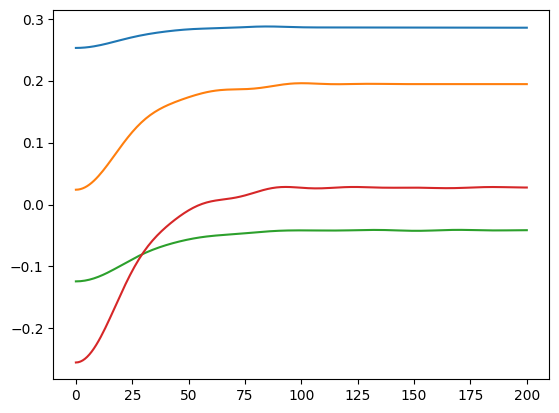

In [45]:
plt.plot((res_dict_lin_resp['Rd2phi']/(res_dict_lin_resp['Cdphi'][:,0:1]+res_dict_lin_resp['Rd2phi'][:,0:1])).T)

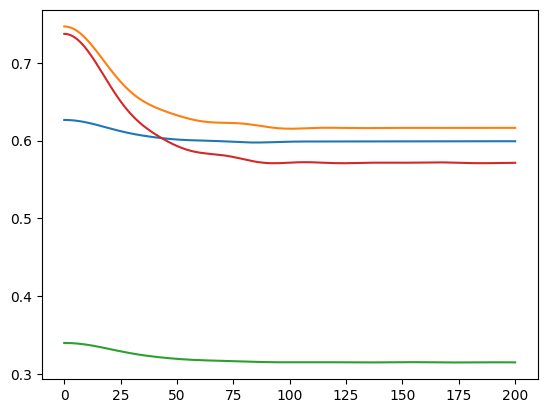

In [53]:
plt.plot(((Md2phi/Mdphi)[:,None] * Rdphi[:,0:1]/Cdphi[:,0:1]*(1-alp)).T)

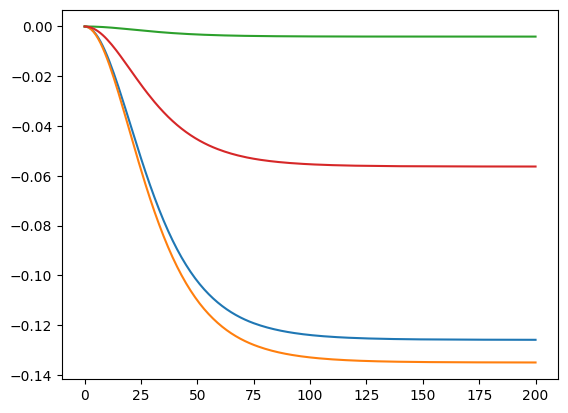

In [54]:
plt.plot(((Md2phi/Mdphi)[:,None] * (Rdphi - Rdphi[:,0:1])/Cdphi[:,0:1]).T)

In [17]:
print(Mdphi)
print(-Md2phi*Rdphi[:,-1]/(Cdphi[:,-1]+Rd2phi[:,-1]))
print(Mdphi - Md2phi*Rdphi[:,-1]/(Cdphi[:,-1]+Rd2phi[:,-1]))

[1113.8535 1502.5425 2578.8118 1727.7719]
[ -639.07227683  -994.40873637  -830.00564724 -1150.57919738]
[ 474.78123879  508.1337441  1748.80612033  577.19265321]


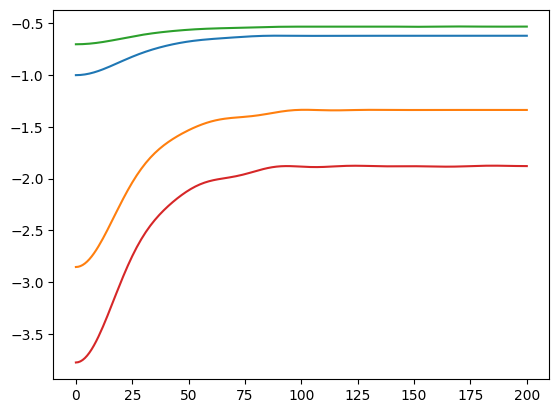

In [56]:
alp = res_dict_lin_resp['Rd2phi']/(res_dict_lin_resp['Cdphi'][:,0:1]+res_dict_lin_resp['Rd2phi'][:,0:1])
bet = (Md2phi/Mdphi)[:,None] * Rdphi[:,0:1]/Cdphi[:,0:1]*(1-alp)
gam = (Md2phi/Mdphi)[:,None] * (Rdphi - Rdphi[:,0:1])/Cdphi[:,0:1]

plt.plot((alp - (gam + bet) / (1-bet[:,0:1]) * (1-alp)).T)

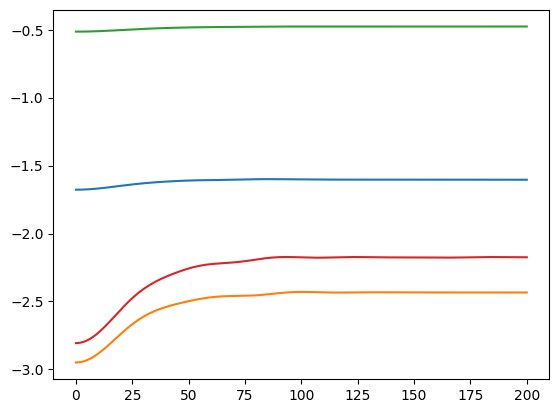

In [58]:
plt.plot(-(bet / (1-bet[:,0:1])).T)

In [143]:
print(np.diag(Mdphip)@muWpp)
print(np.linalg.eigvals(np.diag(Mdphip)@muWpp))
print()
print(np.diag(Md2phip)@muWpp)
print(np.linalg.eigvals(np.diag(Mdphip)@muWpp))

[[ 1.12578548 -5.10767309]
 [ 3.29941488 -6.55739625]]
[-2.71580538+1.44724296j -2.71580538-1.44724296j]

[[  13.65557311  -61.95514536]
 [  83.04538127 -165.04789244]]
[-2.71580538+1.44724296j -2.71580538-1.44724296j]


In [183]:
print(np.diag(Cdphip[:,-1])@SigWpp)
print(np.linalg.eigvals(np.diag(Cdphip[:,-1])@SigWpp))
print()
print(np.diag(Rd2phip[:,-1])@SigWpp)
print(np.linalg.eigvals(np.diag(Rd2phip[:,-1])@SigWpp))

[[0.00880007 0.26477973]
 [0.13304425 0.76815505]]
[-0.03505806  0.81201317]

[[-0.00033713 -0.01014357]
 [ 0.00374876  0.02164415]]
[0.0015558  0.01975121]


In [202]:
print(np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp))
print(np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp)@np.diag(Rd2phip[:,-1])@SigWpp)
print(np.linalg.inv(np.eye(2)-np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp)@np.diag(Rd2phip[:,-1])@SigWpp))
print(np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp)@np.linalg.inv(np.eye(2)-np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp)@np.diag(Rd2phip[:,-1])@SigWpp)@np.linalg.inv(np.eye(2)-np.diag(Cdphip[:,-1])@SigWpp))
print()
print(np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb))
print(np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb)@np.diag(Rd2phib[:,-1])@SigWbb)
print(np.linalg.inv(np.eye(2)-np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb)@np.diag(Rd2phib[:,-1])@SigWbb))
print(np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb)@np.linalg.inv(np.eye(2)-np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb)@np.diag(Rd2phib[:,-1])@SigWbb)@np.linalg.inv(np.eye(2)-np.diag(Cdphib[:,-1])@SigWbb))

[[1.19153147 1.3607947 ]
 [0.68376044 5.09411955]]
[[0.0046996  0.01736685]
 [0.01886612 0.10332209]]
[[1.00509078 0.01946659]
 [0.02114713 1.11563723]]
[[ 2.51517641  9.52065592]
 [ 4.84226984 30.1004388 ]]

[[1.18610611 0.40620133]
 [1.9234171  4.44212285]]
[[0.05138085 0.12673751]
 [0.51222167 0.94170341]]
[[ -6.06218085 -13.1792567 ]
 [-53.26521785 -98.64558426]]
[[ -141.32974464  -259.14444949]
 [-1186.06584853 -2159.97179607]]


In [ ]:
print(Mpp[:2,:2] - np.eye(2))
print(Mbb[:2,:2] - np.eye(2))

In [223]:
Bpprsh@Dpprsh@Cpprsh

array([[ 0.06809819, -0.11063909],
       [ 0.34835194, -0.73560623]])

In [226]:
print((np.linalg.inv(Mpp))[:2,:2])
print((np.linalg.inv(Mbb))[:2,:2])
print()
print(-(np.linalg.inv(Mpp)@Mpb)[:2,:2])
print(-(np.linalg.inv(Mbb)@Mbp)[:2,:2])
print()
print(-(np.linalg.inv(App)@Apb))
print(-(np.linalg.inv(Abb)@Abp))
print()
print((np.linalg.det(Mpp[:2,:2])))
print((np.linalg.det(Mbb[:2,:2])))

[[ 0.45318801 -0.13737111]
 [ 0.21224079 -0.03291633]]
[[ 0.40244596 -0.13228828]
 [ 0.59317858 -0.20939224]]

[[-1.41155321 -0.02393175]
 [ 0.54788331 -0.17994682]]
[[-0.05095812 -0.00942705]
 [ 0.05058499 -0.086183  ]]

[[-1.35458515 -0.05595746]
 [ 0.5356141  -0.17559044]]
[[-0.05187832 -0.00930821]
 [ 0.04361715 -0.07358888]]

15.901721844366403
18.512751464424245


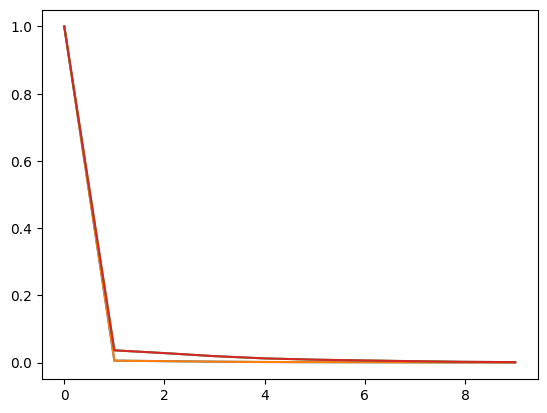

In [194]:
_,a = dmft.get_time_freq_func(np.einsum('ijk,jl->ilk',np.eye(2)[:,:,None]*Cdphip[None,:,:],SigWpp).reshape(4,-1))
plt.plot((a[:,:10]/a[:,0:1]).T)

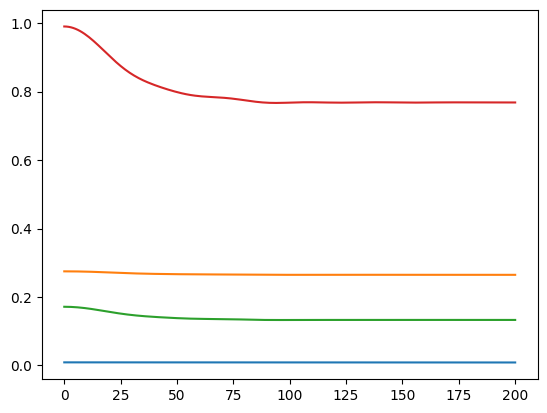

In [189]:
plt.plot(np.einsum('ijk,jl->ilk',np.eye(2)[:,:,None]*Cdphip[None,:,:],SigWpp).reshape(4,-1).T)

In [62]:
np.linalg.inv(Mpp)[:2,:2]

array([[ 0.45318801, -0.13737111],
       [ 0.21224079, -0.03291633]])

In [69]:
np.linalg.inv(App)

array([[ 0.47525647, -0.32120252],
       [ 0.2074879 , -0.00791018]])

In [147]:
-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh

array([[ -2.18600316,   4.54021263],
       [-11.60673909,  24.27102936]])

In [47]:
print(-Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpb.reshape(NP*NT,NP))
print(Apb)

[[ -5.64299944   0.79096129]
 [-29.96190644   4.22831404]]
[[-2.90612885  0.88981994]
 [-8.51718637  1.14237967]]


In [149]:
print(-np.linalg.inv(App)@Apb)
print(-np.linalg.inv(App)@(-Bpprsh@np.linalg.inv(Dpprsh)@Cpbrsh))
print(-np.linalg.inv(App)@(Apb-Bpprsh@np.linalg.inv(Dpprsh)@Cpbrsh))
print(-np.linalg.inv(App-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh)@Apb)
print(-np.linalg.inv(App-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh)@(Apb-Bpprsh@np.linalg.inv(Dpprsh)@Cpbrsh))
print((-np.linalg.inv(Mpp)@Mpb)[:2,:2])
print((-np.linalg.inv(Mpp)@Mpb)[:2,2:].reshape(2,2,NT).sum(-1))

[[-1.35458515 -0.05595746]
 [ 0.5356141  -0.17559044]]
[[-6.94196777  0.98223564]
 [ 0.93385003 -0.13066817]]
[[-8.29655292  0.92627818]
 [ 1.46946412 -0.30625861]]
[[ 0.14700741 -0.24632576]
 [ 0.33644459 -0.15125314]]
[[-1.41155321 -0.02393175]
 [ 0.54788331 -0.17994682]]
[[-1.41155321 -0.02393175]
 [ 0.54788331 -0.17994682]]
[[-5.58463979e-04 -1.69366872e-04]
 [ 1.40655807e-05  2.39018976e-05]]


In [175]:
print(np.diag(Mdphip))
print(np.diag(Md2phip)@SigWpp@(np.eye(2)[:,:,None]*del_vec[None,None,:]).reshape(NP,NP*NT)@np.linalg.inv(Dpprsh)@(np.eye(2)[:,None,:]*Rdphip[:,:,None]).reshape(NP*NT,NP))
print()
print(np.diag(Mdphip)@muWpp)
print(np.diag(Md2phip)@SigWpp@(np.eye(2)[:,:,None]*del_vec[None,None,:]).reshape(NP,NP*NT)@np.linalg.inv(Dpprsh)@(np.eye(2)[:,None,:]*Rdphip[:,:,None]).reshape(NP*NT,NP)@muWpp)

[[2578.8118    0.    ]
 [   0.     1727.7719]]
[[ 175.79180143 1104.53572292]
 [1081.12977964 5830.8343613 ]]

[[ 1.12578548 -5.10767309]
 [ 3.29941488 -6.55739625]]
[[  2.18600316  -4.54021263]
 [ 11.60673909 -24.27102936]]


In [173]:
print(Dpp[:,0,:].sum(-1))
print(Dbb[:,0,:].sum(-1))

[[ 0.99187046 -0.24460455]
 [-0.13664007  0.21108384]]
[[ 0.9842508  -0.14087462]
 [-0.5832425  -0.00110024]]


In [168]:
print(np.diag(Mdphib))
print(np.diag(Md2phib)@SigWbb@(np.eye(2)[:,:,None]*del_vec[None,None,:]).reshape(NP,NP*NT)@np.linalg.inv(Dbbrsh)@(np.eye(2)[:,None,:]*Rdphib[:,:,None]).reshape(NP*NT,NP))
print()
print(np.diag(Mdphib)@muWbb)
print(np.diag(Md2phib)@(SigWbb[:,:,None]*del_vec[None,None,:]).reshape(NP,NP*NT)@np.linalg.inv(Dbbrsh)@(np.eye(2)[:,None,:]*Rdphib[:,:,None]).reshape(NP*NT,NP)@muWbb)

[[1113.8535    0.    ]
 [   0.     1502.5425]]
[[  -815.50272088  -5639.86694381]
 [ -2356.25370893 -17197.15379225]]

[[ 1.60464437 -2.41814716]
 [ 9.46873603 -6.25061846]]
[[ -36.71619838   25.23243845]
 [-111.76765819   76.6560033 ]]


In [176]:
print(-np.linalg.inv(App)@Apb)
print(-np.linalg.inv(Abb)@Abp)

[[-1.35458515 -0.05595746]
 [ 0.5356141  -0.17559044]]
[[-0.05187832 -0.00930821]
 [ 0.04361715 -0.07358888]]


In [150]:
print(App)
print(-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh)
print(App - Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh)

[[-0.12578548  5.10767309]
 [-3.29941488  7.55739625]]
[[ -2.18600316   4.54021263]
 [-11.60673909  24.27102936]]
[[ -2.31178864   9.64788572]
 [-14.90615396  31.82842561]]


In [154]:
print(-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh / (np.diag(Mdphip)@muWpp))
print(-Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh / App)

[[-1.94175817 -0.8889004 ]
 [-3.5178174  -3.70132114]]
[[17.37881899  0.8889004 ]
 [ 3.5178174   3.21155972]]


In [35]:
(np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpp.reshape(NP*NT,NP)).reshape(NP,NT,NP)[:,-1,:]

array([[-1079.65051252,  2647.20670077],
       [-3576.23892965,  7434.28689299]])

In [151]:
np.linalg.eigvals(np.linalg.inv(App)@Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh)

array([-3.44581323,  0.00656059])

In [27]:
1 - (Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpp.reshape(NP*NT,NP))/App

array([[18.37881899,  1.8889004 ],
       [ 4.5178174 ,  4.21155972]])

In [140]:
App - Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpp.reshape(NP*NT,NP)

array([[ -2.31178864,   9.64788572],
       [-14.90615396,  31.82842561]])

In [81]:
print(Apb)
print(-Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpb.reshape(NP*NT,NP))
print(Apb - Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpb.reshape(NP*NT,NP))

[[-2.90612885  0.88981994]
 [-8.51718637  1.14237967]]
[[ -5.64299944   0.79096129]
 [-29.96190644   4.22831404]]
[[ -8.54912829   1.68078123]
 [-38.4790928    5.37069371]]


In [9]:
print(np.linalg.inv(App))
print(np.linalg.inv(App - Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh))
print(np.linalg.inv(App) + np.linalg.inv(App)@Bpprsh@np.linalg.inv(Dpprsh)@Cpprsh@np.linalg.inv(App))

[[ 0.47525647 -0.32120252]
 [ 0.2074879  -0.00791018]]
[[ 0.45318801 -0.13737111]
 [ 0.21224079 -0.03291633]]
[[ 0.36704394  0.49797704]
 [ 0.22378914 -0.11817466]]


In [80]:
Cpp.reshape(NP*NT,NP)@np.linalg.inv(App)@Bpp.reshape(NP,NP*NT)

array([[-0.02504096,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02504064,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02503982,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.09110496,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.09110567,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.09110496,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
Dpp

array([[[[ 1.80991859e+02, -1.79999988e+02,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.44604548e-01,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[-8.99989859e+01,  1.80990850e+02, -8.99999941e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.03349400e-02, -2.74949415e-01,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 1.00629282e-03, -8.99999941e+01,  1.80990851e+02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.02777136e-02,  0.00000000e+00, -2.74921883e-01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        ...,

        [[ 3.37284119e-04,  0.00000000e+00,  0.00000000e+00, ...,
           1.80991188e+02, -8.99999941e+01,  0.00000000e+00],
         [ 1.01483303e-02,  0.00000000e+00,  0.00000000e+00, ...,
          -2.64777

In [124]:
-(Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))).reshape(NP,NP,NT)

array([[[7.12829428e-06, 1.48676373e-05, 1.53318410e-05, 1.56634880e-05,
         1.58757901e-05, 1.59810022e-05, 1.59905209e-05, 1.59149635e-05,
         1.57642323e-05, 1.55475656e-05, 1.52735772e-05, 1.49502876e-05,
         1.45851494e-05, 1.41850667e-05, 1.37564124e-05, 1.33050436e-05,
         1.28363155e-05, 1.23550970e-05, 1.18657859e-05, 1.13723261e-05,
         1.08782264e-05, 1.03865803e-05, 9.90008856e-06, 9.42108192e-06,
         8.95154579e-06, 8.49314540e-06, 8.04725154e-06, 7.61496632e-06,
         7.19714878e-06, 6.79443981e-06, 6.40728632e-06, 6.03596422e-06,
         5.68060014e-06, 5.34119170e-06, 5.01762618e-06, 4.70969771e-06,
         4.41712269e-06, 4.13955375e-06, 3.87659212e-06, 3.62779849e-06,
         3.39270260e-06, 3.17081148e-06, 2.96161655e-06, 2.76459972e-06,
         2.57923853e-06, 2.40501044e-06, 2.24139647e-06, 2.08788417e-06,
         1.94397012e-06, 1.80916187e-06, 1.68297958e-06, 1.56495732e-06,
         1.45464407e-06, 1.35160448e-06, 1.25541943

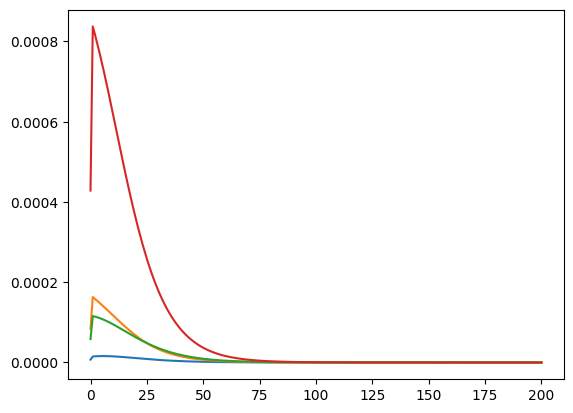

In [13]:
plt.plot(-(Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))).reshape(NP*NP,NT).T)

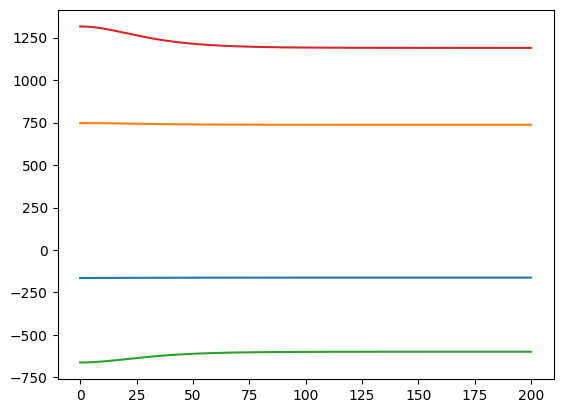

In [36]:
plt.plot(Cpp.transpose((0,2,1)).reshape(4,-1).T)

In [20]:
print(np.sum((Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))).reshape(NP,NP,NT),-1))
print(Cpp[:,-1,:])
print()
print(Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))@Cpp.reshape(NP*NT,NP))
print(np.sum((Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))).reshape(NP,NP,NT),-1)@Cpp[:,-1,:])

[[-0.00046786 -0.00325392]
 [-0.00287658 -0.01718307]]
[[-162.40033877  736.80807938]
 [-598.35565526 1189.19725966]]

[[  2.18600316  -4.54021263]
 [ 11.60673909 -24.27102936]]
[[  2.02298226  -4.2142756 ]
 [ 10.74874256 -22.55354133]]


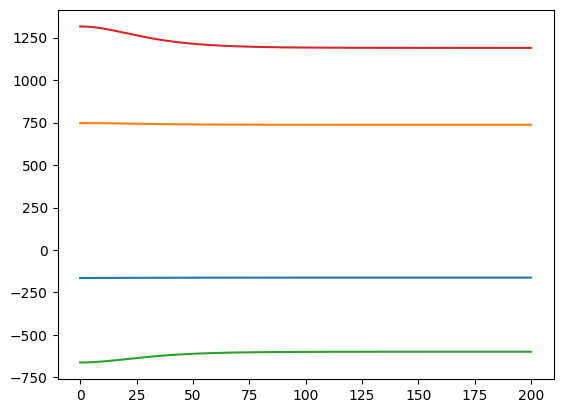

In [15]:
plt.plot(Cpp.transpose((0,2,1)).reshape(NP*NP,NT).T)

In [ ]:
plt.plot(-(Bpp.reshape(NP,NP*NT)@np.linalg.inv(Dpp.reshape(NP*NT,NP*NT))).reshape(NP*NP,NT).T)

In [99]:
-(Cpp.reshape(NP*NT,NP)@np.linalg.inv(App)).reshape(NP,NT,NP)

array([[[ -76.72976351,  -46.96731259],
        [ -76.72877153,  -46.96670539],
        [ -76.72628523,  -46.96518349],
        [ -76.72181497,  -46.96244718],
        [ -76.7153544 ,  -46.95849258],
        [ -76.70690986,  -46.95332356],
        [ -76.69747336,  -46.94754735],
        [ -76.68654252,  -46.94085644],
        [ -76.67362773,  -46.93295113],
        [ -76.65921861,  -46.92413111],
        [ -76.64381752,  -46.9147039 ],
        [ -76.62742444,  -46.90466948],
        [ -76.60904741,  -46.89342065],
        [ -76.59016804,  -46.88186433],
        [ -76.57079267,  -46.87000441],
        [ -76.54992934,  -46.85723369],
        [ -76.52956199,  -46.84476656],
        [ -76.50770032,  -46.83138474],
        [ -76.48534266,  -46.81769932],
        [ -76.46299136,  -46.80401779],
        [ -76.44112969,  -46.79063597],
        [ -76.4182824 ,  -46.77665084],
        [ -76.39542875,  -46.76266182],
        [ -76.37257511,  -46.7486728 ],
        [ -76.35021745,  -46.73498737],


[  1.           1.           1.00491012   1.01963927   1.02209554
   1.04418385   1.07853781   1.08837673   1.12269273   1.17663777
   1.1988273    1.24035969   1.31384283   1.35342013   1.39706917
   1.49001826   1.55211728   1.59266728   1.70499105   1.79486995
   1.82696197   1.95855011   2.08161855   2.09972316   2.25044646
   2.41068301   2.41229269   2.58039347   2.75953617   2.78681117
   2.94806713   3.14594007   3.20508206   3.35310641   3.56951529
   3.66700267   3.79511357   4.02984588   4.17245959   4.27365458
   4.52647982   4.72132872   4.78825953   5.05892944   5.31347533
   5.33842309   5.62667188   5.92360503   5.94875402   6.22914964
   6.54323071   6.62700885   6.86577112   7.19669169   7.34807329
   7.53591117   7.88334628   8.11177031   8.23891174   8.60252023
   8.91791243   8.97408251   9.35350733   9.74070156   9.76630173
  10.13557014  10.53801612  10.65672992  10.94794069  11.36524323
  11.58897841  11.78982128  12.2215706   12.56281832  12.6603852
  13.106157

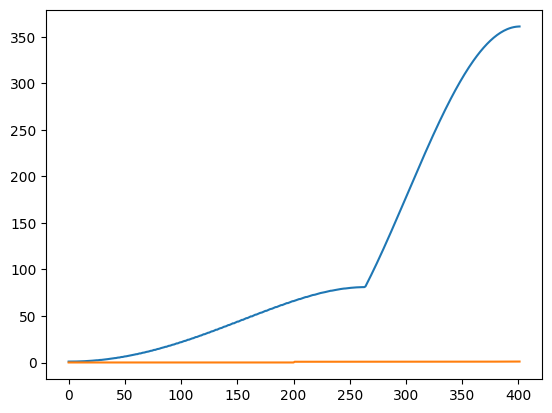

In [123]:
print(np.sort(np.abs(np.linalg.eigvals(D0dis.reshape(NP*NT,NP*NT)))))
print(np.sort(np.abs(np.linalg.eigvals((Dpp-D0dis).reshape(NP*NT,NP*NT)))))
print()
plt.plot(np.sort(np.abs(np.linalg.eigvals(D0dis.reshape(NP*NT,NP*NT)))))
plt.plot(np.sort(np.abs(np.linalg.eigvals((Dpp-D0dis).reshape(NP*NT,NP*NT)))))

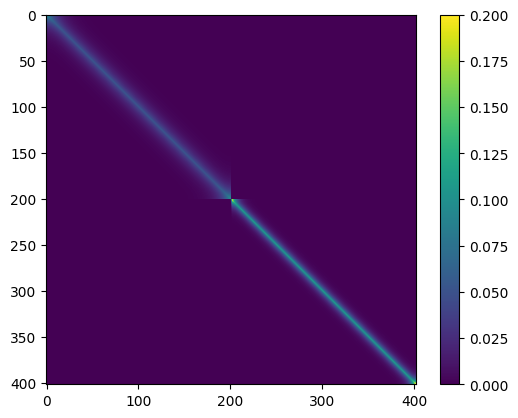

In [119]:
plt.imshow(np.linalg.inv(D0dis.reshape(NP*NT,NP*NT)))
plt.colorbar()

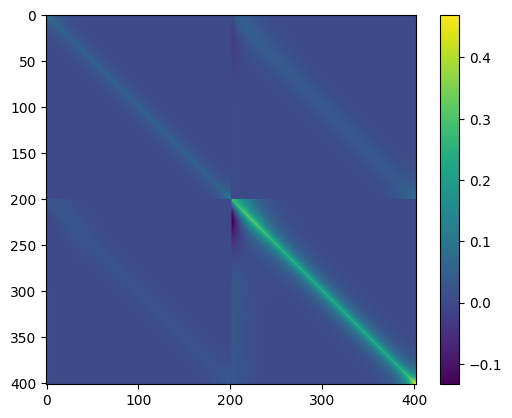

In [70]:
plt.imshow(np.linalg.inv(Dpp.reshape(NP*NT,NP*NT)))
plt.colorbar()

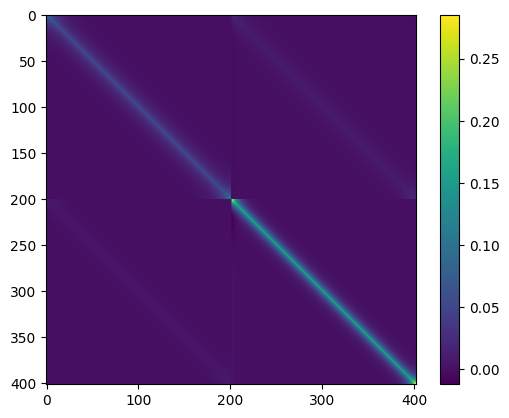

In [73]:
plt.imshow(np.linalg.inv(D0dis.reshape(NP*NT,NP*NT)) -\
    np.linalg.inv(D0dis.reshape(NP*NT,NP*NT))@(Dpp-D0dis).reshape(NP*NT,NP*NT)@np.linalg.inv(D0dis.reshape(NP*NT,NP*NT)))
plt.colorbar()

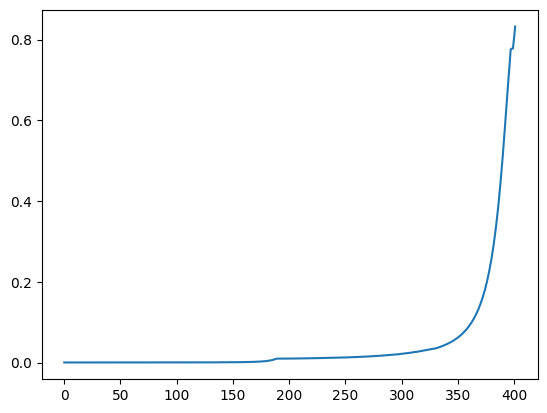

In [78]:
plt.plot(np.sort(np.abs(np.linalg.eigvals(np.linalg.inv(D0dis.reshape(NP*NT,NP*NT))@(Dpp-D0dis).reshape(NP*NT,NP*NT)))))

In [117]:
np.linalg.inv(Dpp.reshape(NP*NT,NP*NT)).reshape(NP,NT,NP,NT)[:,0,:,:].sum(-1)

array([[1.20288546, 1.41068765],
       [0.78352321, 5.68050563]])

In [118]:
np.linalg.inv(np.linalg.inv(D0dis.reshape(NP*NT,NP*NT)) -\
    np.linalg.inv(D0dis.reshape(NP*NT,NP*NT))@(Dpp-D0dis).reshape(NP*NT,NP*NT)@np.linalg.inv(D0dis.reshape(NP*NT,NP*NT))).reshape(NP,NT,NP,NT)[:,0,:,:].sum(-1)

array([[ 1.01066955, -0.13818591],
       [-0.07719239,  0.56963906]])